In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Q-1,2,3
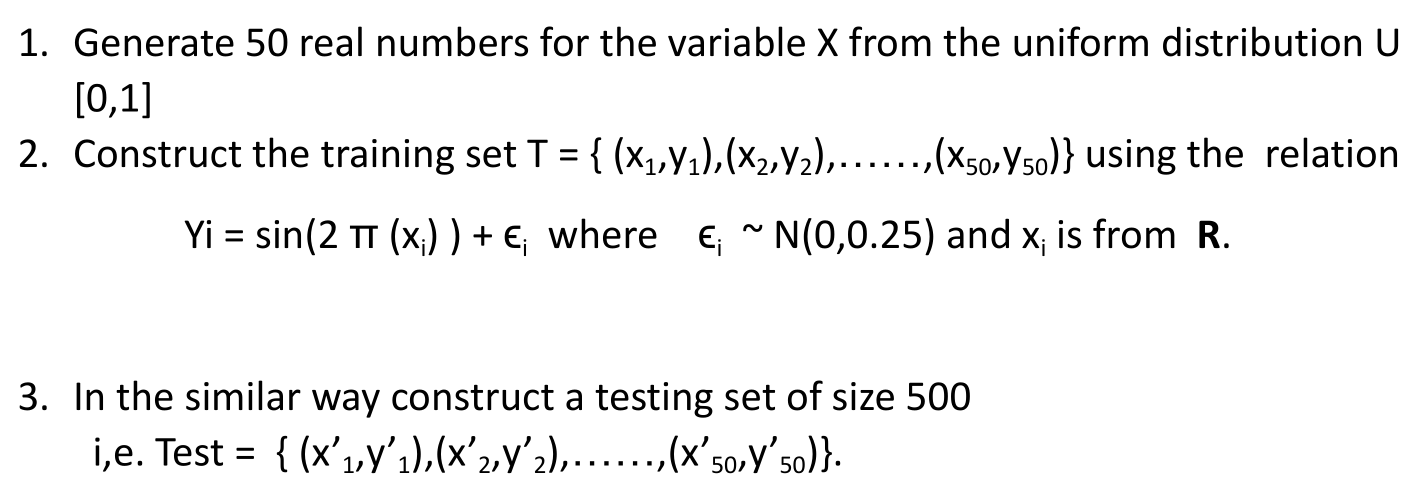

In [57]:
class Generate_dataset:
  '''
    m : no of features
    n : no of samples 
  '''
  def getX(self, n, m):
    # sort will help to plot data properly 
    X = np.sort(np.random.uniform(0.0, 1.0, (m*n))).reshape(n, m)
    return X

  def getY(self, X):
    n = X.shape[0]
    ep = np.random.normal(loc=0.0, scale =0.25, size =n) # eplsilon
    y = np.array([np.sin(2*np.pi*X[i])+ ep[i] for i in range(n)]).reshape(n,1)
    return y

  def getY_noNoise(self, X):
    n = X.shape[0]
    ep = np.random.normal(loc=0.0, scale =0.25, size =n) # eplsilon
    y = np.array([np.sin(2*np.pi*X[i]) for i in range(n)]).reshape(n,1)
    return y

In [59]:
data_obj = Generate_dataset()
xTrain = data_obj.getX(50,1)
yTrain = data_obj.getY(xTrain)
yTrain_noNoise = data_obj.getY_noNoise(xTrain)
xTest = data_obj.getX(500,1)
yTest = data_obj.getY(xTest)
yTest_noNoise = data_obj.getY_noNoise(xTest)

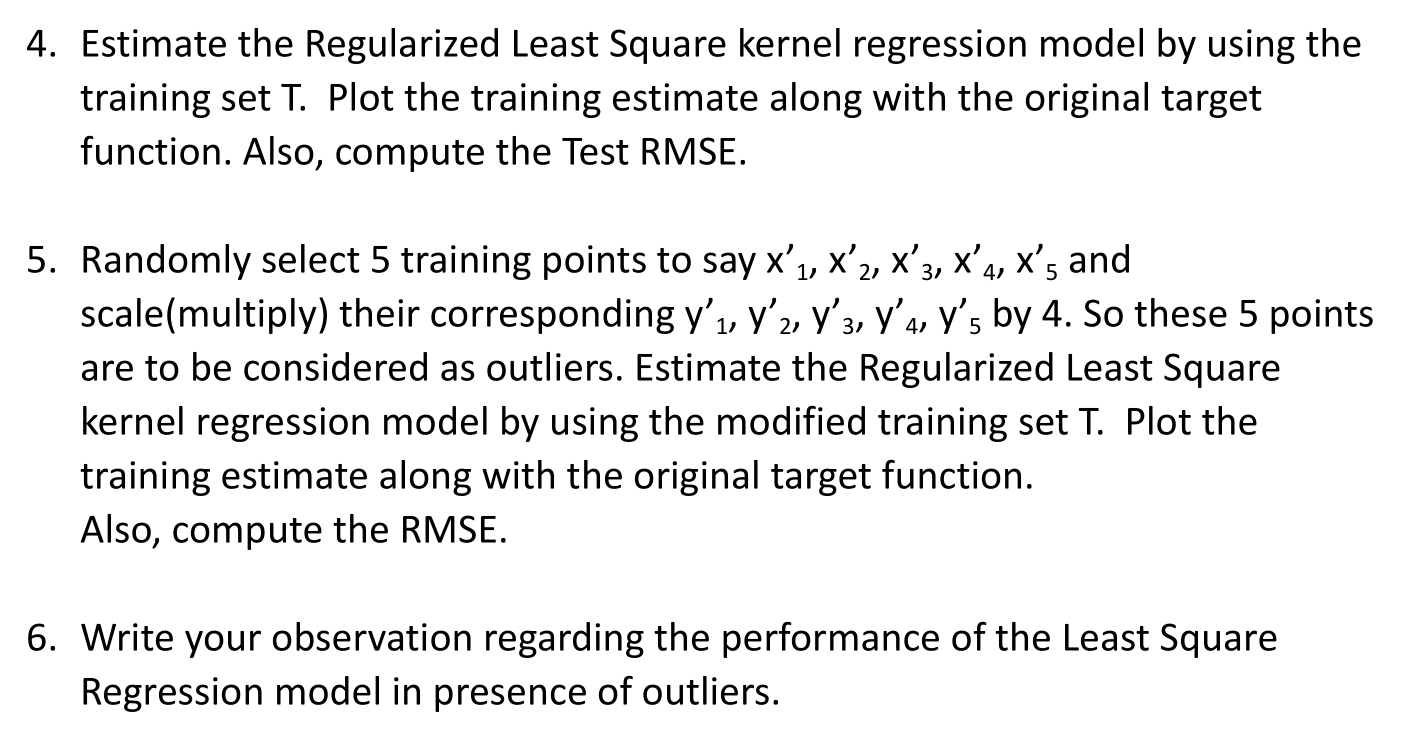

In [159]:
class SVR:
  def rbf_kernal_fun(self, x,y):
    sigma= 1.2
    val = np.exp(-(1 / (sigma**2)) * np.sum((x-y)**2))
    return val

  def construct_kernel_matrix(self, x1, x2):
    '''x1 : n_samples x m_features'''
    # applying kernel fun to each combinations of test set samples 
    K = np.zeros((x1.shape[0],x2.shape[0]))
    for i in range(x1.shape[0]):
      for j in range(x2.shape[0]):
        K[i,j] = self.rbf_kernal_fun(x1[i,:], x2[j,:])
    
    # K : n x n
    return K

  def fit_fun(self, X, y, n_iter=1000, lr= 0.001, alpha=0.000001, lamda=0.000001, eta=0.00001, norm_of_error = 'l2', training_type = 'gred_des'):

    K = self.construct_kernel_matrix(X,X) # n x n
    
    # added bias col x0 = 1
    x0 = np.ones((K.shape[0], 1)) # n x 1 col vector
    K = np.c_[x0, K] 
    tmp = K.copy()
    # after adding bias col x0, now, no of features m+1
    #n_samples, m_features = np.shape(K)

    training_errors = []

    u = np.random.randn(K.shape[1], 1) # n+1 x 1 col vector : implicit bias
    d_u = np.random.randn(1,K.shape[1])
    #d_u =  np.random.randn(K.shape[1], 1)
    if(training_type == 'least_squre'):

        '''Forward prop'''
        # hypothesis h : y_hat : y_pred
        y_pred = K @ u

        '''Finding cost'''
        error = y - y_pred # n x 1
        regularization = (alpha/2) * u.T @ u
        # All are equivalent: u.T @ u ~ u @ u.T ~ np.sum(u**2) ~ np.linalg.norm(u) ** 2 
        if(norm_of_error == 'l1'):
          cost_fun = np.absolute(error) + regularization
        else:
          cost_fun = error.T @ error +  regularization
        
        '''Training model in 1 step'''
        I = np.identity(K.shape[1]) 
        u = np.linalg.pinv( (K.T @ K) + (lamda * I )) @ (K.T @ y)

    else:

      for _ in range(n_iter):

        '''Forward prop'''
        # hypothesis h : y_hat : y_pred
        y_pred = K @ u # (n x n+1) x (n+1 x 1) = n x 1 

        '''Finding cost'''
        error = y - y_pred # n x 1
        regularization = (lamda/2) * u.T @ u
        # All are equivalent: u.T @ u ~ u @ u.T ~ np.sum(u**2) ~ np.linalg.norm(u) ** 2 
        if(norm_of_error == 'l1'):
          cost_fun = np.absolute(error) + regularization
        else:
          cost_fun = error.T @ error +  regularization # norm_of_error == 'l1'

        '''Back prop ~ Training model by updating weights'''
        if(norm_of_error == 'l1'):

          for i in range(error.shape[0]): # implicit bias: n+1 x 1 : y_pred.shape[0] ~ u.shape[0]
            if(error[i] > 0):
              tmp[i, :] = - K[i, :] # diff of sum of all  (y - y_pred) = y - Ku
            elif(error[i] < 0):
              tmp[i, : ] =  K[i, :]
            else:
              tmp[i, :] = 0
          
          for i in range(error.shape[0]): 
            d_u +=  tmp[i, :]
          

          #print(d_u.shape)
          I = np.identity(K.shape[1])  
          I[0][0] = 0
          gred_cost_fun = (lamda * (I@u)) + d_u.T 
          
          u = u - (lr *gred_cost_fun)

        else:
          d_u = (lamda * u) - (K.T @ (y- (K@u)))
          
          u = u -  (lr*d_u)

        err = self.find_rmse(y, y_pred)
        training_errors.append(err)

    return u,training_errors

  def predict(self, xTest, xTrain, u):
    K = self.construct_kernel_matrix(xTest,xTrain)
    # added bias col x0 = 1
    x0 = np.ones((K.shape[0], 1)) # n x 1 col vector
    K = np.c_[x0, K] 
    u = np.array(u).reshape(K.shape[1],1)
    Y_pred = K @ u

    return Y_pred

  def find_rmse(self, y, y_pred):
    x = np.sqrt(np.mean((y_pred - y)**2))
    return x


  def pltGraph(self, x, y,y_new, y_pred):

    fig = plt.figure(figsize=(8,6))

    #y with epsilon 
    plt.plot(x, y, 'b.')

    #y without epsilon 
    a,b = zip(*sorted(zip(x, y_new)))
    plt.plot(a, b, 'y')

    #prediction
    xs, ys = zip(*sorted(zip(x, y_pred)))

    plt.plot(xs,ys,'g')
    plt.legend([ "Actual y with noise","Actual y","my predictions"])
    plt.xlabel('X - Input')
    plt.ylabel('y - target / true')
    plt.title('Prediction on Train dataset ')
    plt.show()
   

In [153]:
obj = SVR()

In [92]:
#fit(self, X, y, n_iter=1000, lr= 0.001, alpha=0.01, lambda=0.01, norm_of_error = 'l2', training_type = 'gred_des')
u = obj.fit_fun(xTrain,yTrain, norm_of_error = 'l2', training_type = 'least_squre')
yTrain_pred = obj.predict(xTrain, xTrain, u)
yTest_pred = obj.predict(xTest, xTrain, u)
rmse = obj.find_rmse(yTest, yTest_pred)
rmse

0.2507197479017749

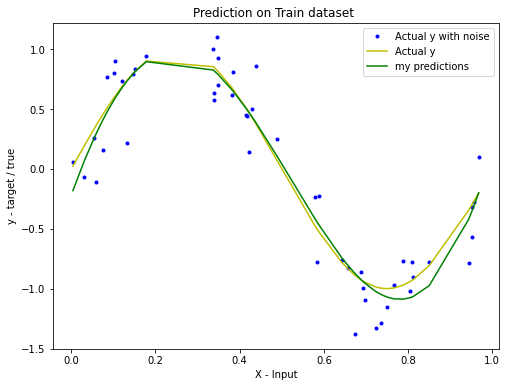

In [87]:
obj.pltGraph(xTrain, yTrain, yTrain_noNoise ,yTrain_pred)

In [132]:
yTrain_scale =yTrain_noNoise.copy()
yTrain_scale[0] *= 4
yTrain_scale[5] *= 4
yTrain_scale[8] *= 4
yTrain_scale[24] *= 4
yTrain_scale[25] *= 4

In [143]:
u,training_errors = obj.fit_fun(xTrain,yTrain_scale, norm_of_error = 'l2', training_type = 'least_squre')
yTrain_pred = obj.predict(xTrain, xTrain, u)
rmse = obj.find_rmse(yTrain_scale, yTrain_pred)
rmse

0.4013976647767409

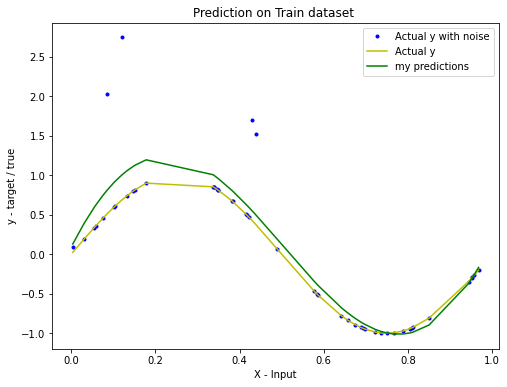

In [144]:
obj.pltGraph(xTrain, yTrain_scale, yTrain_noNoise ,yTrain_pred)

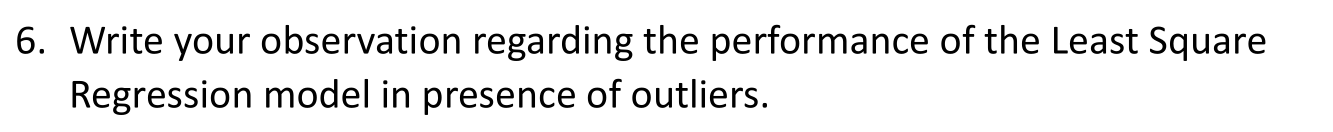

As we can observe from above graph that due to outliers we get high rmse and also out model misguided by outlier ie due to just few outliers models try to fit them to and during that for other data it give bad predictions which you can see in green line.

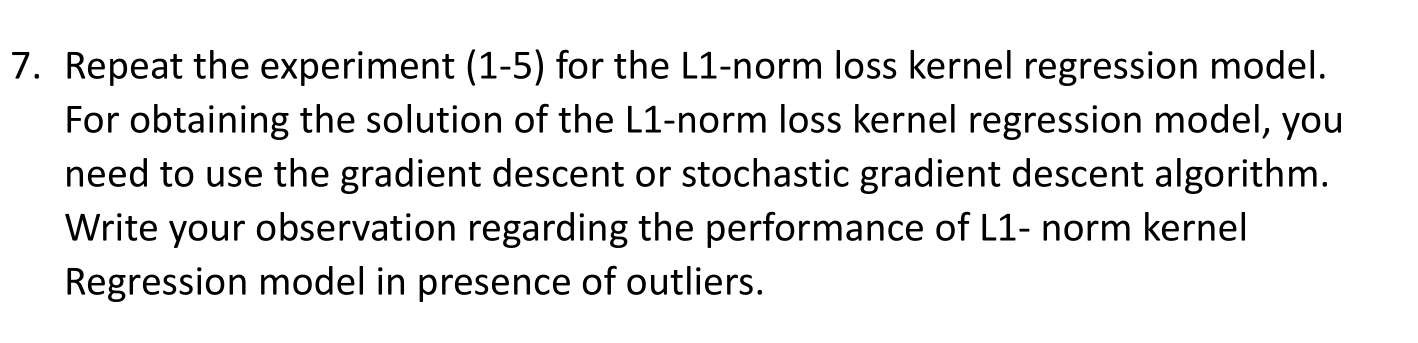

In [165]:
obj = SVR()
#fit(self, X, y, n_iter=1000, lr= 0.001, alpha=0.01, lambda=0.01, norm_of_error = 'l2', training_type = 'gred_des')
'''using outliers'''
u,training_errors = obj.fit_fun(xTrain,yTrain_scale, norm_of_error = 'l1', training_type = 'gred_des')
yTrain_pred = obj.predict(xTrain, xTrain, u)
rmse = obj.find_rmse(yTrain_scale, yTrain_pred)
rmse

12.999502516502456

In [168]:
u,training_errors = obj.fit_fun(xTrain,yTrain,n_iter=1000,lamda =0.001, norm_of_error = 'l1', training_type = 'gred_des')
yTrain_pred = obj.predict(xTrain, xTrain, u)
yTest_pred = obj.predict(xTest, xTrain, u)
rmse = obj.find_rmse(yTest, yTest_pred)
rmse

9.110188806597842

As we can observe from rmse value due to outlier model mislead in prediction and due that we are having high error val compare to non outlier case, its similer to obervation that we did for least squre l2 regression.